In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from deap import base, creator, tools, algorithms

In [2]:
data = pd.read_csv('DATA_DESA.csv')

df = pd.DataFrame(data)

# Normalisasi MinMax
scaler = MinMaxScaler()
df['jumlah_kecelakaan'] = scaler.fit_transform(df[['jumlah_kecelakaan']])

# Menambahkan kolom lag (pergeseran)
df['jumlah_kecelakaan_lag'] = df['jumlah_kecelakaan'].shift(1)
df = df.dropna() # Menghapus baris dengan nilai NaN

In [3]:
# Memisahkan data latih dan data uji sesuai rasio (0.8 untuk 80:20)
train_size = int(0.7 * len(df))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Memisahkan fitur dan target untuk data latih
X_train = train_data['jumlah_kecelakaan_lag'].values.reshape(-1, 1)
y_train = train_data['jumlah_kecelakaan'].values

# Memisahkan fitur dan target untuk data uji
X_test = test_data['jumlah_kecelakaan_lag'].values.reshape(-1, 1)
y_test = test_data['jumlah_kecelakaan'].values

In [4]:
# Define evaluation function
def evaluate(individual):
    epsilon, C = individual
    
    if epsilon <= 0 or C <= 0 :
        return float('inf'),
    
    svr = SVR(kernel='linear', epsilon=epsilon, C=C)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    return mape,

epsilon range=(1e-07, 0.0001): 46.8006
epsilon range=(1e-07, 0.001): 46.8009
epsilon range=(1e-07, 0.01): 46.8023
epsilon range=(1e-05, 0.0001): 46.8019
epsilon range=(1e-05, 0.001): 46.8005
epsilon range=(1e-05, 0.01): 46.8020
epsilon range=(0.001, 0.1): 46.2206
epsilon range=(0.001, 1): 45.7102
epsilon range=(0.001, 5): 45.7560

Rentang epsilon optimal: (0.001, 1)
MAPE terbaik: 45.7102
[0.29300940674222, 3.096547519947859]


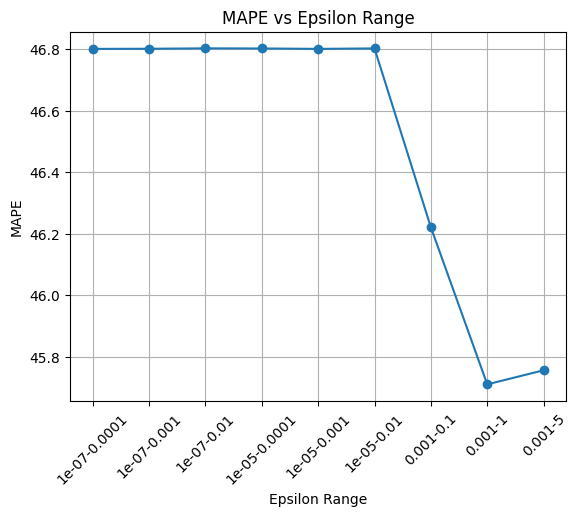

In [5]:
def main():
    # Setup DEAP framework
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    
    epsilon_ranges = [(0.0000001, 0.0001), (0.0000001, 0.001), (0.0000001, 0.01), (0.00001, 0.0001), (0.00001, 0.001), (0.00001, 0.01), (0.001, 0.1), (0.001, 1), (0.001, 5)]
    C_range = (0.0001, 50)
    
    def create_individual(epsilon_range):
        epsilon = random.uniform(*epsilon_range)
        C = random.uniform(*C_range)
        return creator.Individual([epsilon, C])
    
    toolbox.register("individual", create_individual, epsilon_ranges[0])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("mate", tools.cxUniform, indpb=0.5)  # Menggunakan crossover uniform 
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # Menggunakan mutasi gaussian
    toolbox.register("select", tools.selTournament, tournsize=3) # Menggunakan seleksi turnamen
    toolbox.register("evaluate", evaluate)
    
    population_size = 260
    num_generations = 90
    crossover_rate = 0.5
    mutation_rate = 0.5

    results = []
    
    for epsilon_range in epsilon_ranges:
        toolbox.unregister("individual")
        toolbox.register("individual", create_individual, epsilon_range)
        population = toolbox.population(n=population_size)

        for generation in range(num_generations):
            offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
            for ind in offspring:
                ind[0] = max(min(ind[0], max(epsilon_range)), min(epsilon_range))
                ind[1] = max(min(ind[1], C_range[1]), C_range[0])
                
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit

            population = toolbox.select(offspring, k=len(population))

        best_individual = tools.selBest(population, k=1)[0]
        mape = best_individual.fitness.values[0]

        results.append((epsilon_range, mape))
        print(f"epsilon range={epsilon_range}: {mape:.4f}")

    best_result = min(results, key=lambda x: x[1])
    best_epsilon_range = best_result[0]
    best_mape = best_result[1]

    print(f"\nRentang epsilon optimal: {best_epsilon_range}")
    print(f"MAPE terbaik: {best_mape:.4f}")
    print(best_individual)
    
    # Plot hasil
    fig, ax = plt.subplots()
    epsilon_ranges_str = [f"{r[0]}-{r[1]}" for r in epsilon_ranges]
    mapes = [r[1] for r in results]
    ax.plot(epsilon_ranges_str, mapes, marker='o')
    ax.set_xlabel('Epsilon Range')
    ax.set_ylabel('MAPE')
    ax.set_title('MAPE vs Epsilon Range')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

if __name__ == "__main__":
    main()